ARIMA

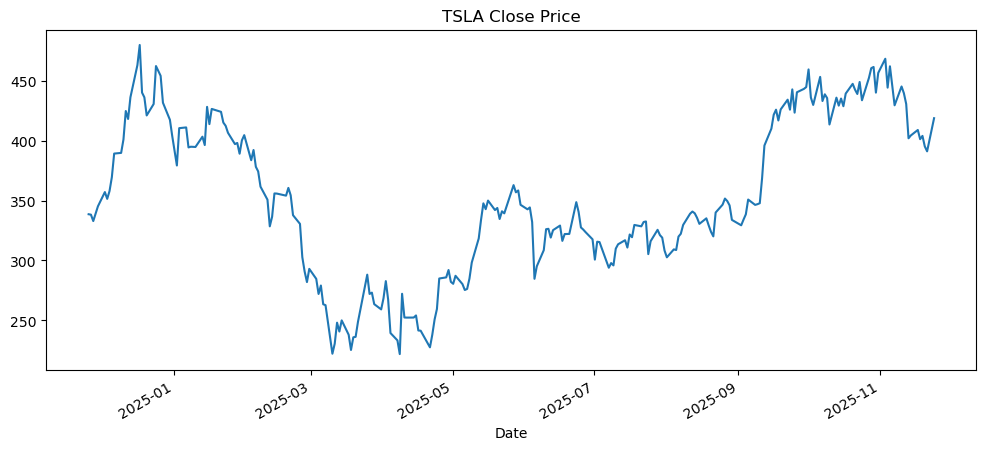

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = pd.read_parquet("../data/processed/TSLA_clean.parquet")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

close = df["Close"]
close.plot(figsize=(12,5), title="TSLA Close Price")
plt.show()


In [2]:
result = adfuller(close.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -1.500388405915515
p-value: 0.5333191913138582


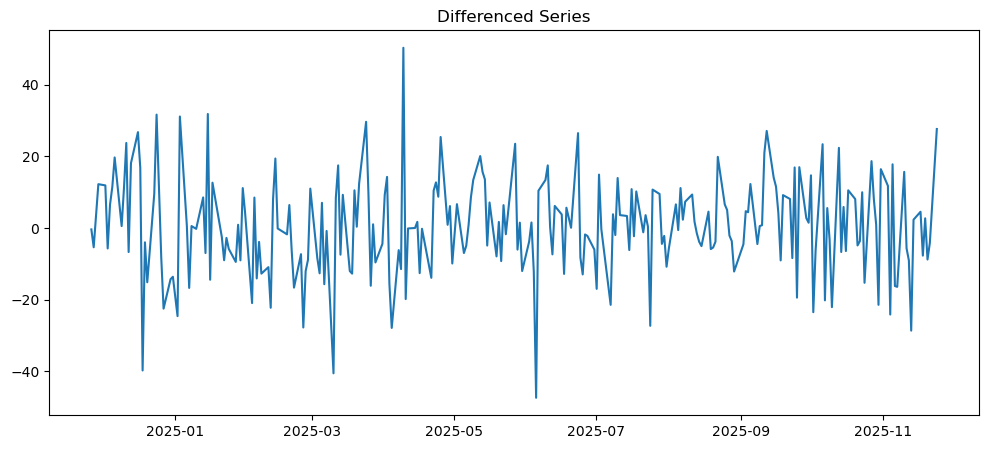

ADF Statistic: -16.36600513823286
p-value: 2.8403307583195456e-29


In [3]:
close_diff = close.diff().dropna()

plt.figure(figsize=(12,5))
plt.plot(close_diff)
plt.title("Differenced Series")
plt.show()

result = adfuller(close_diff)
print("ADF Statistic:", result[0])
print("p-value:", result[1])


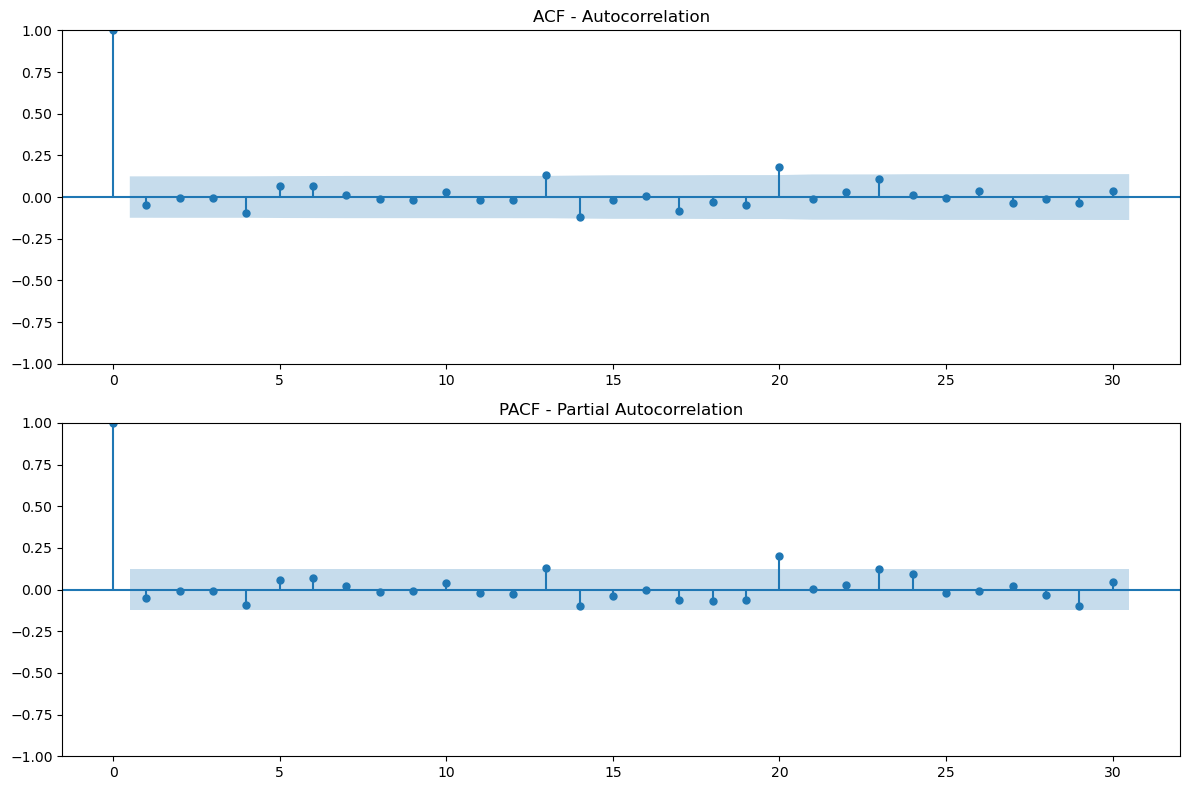

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1, figsize=(12,8))

plot_acf(close_diff, ax=ax[0], lags=30)
ax[0].set_title("ACF - Autocorrelation")

plot_pacf(close_diff, ax=ax[1], lags=30)
ax[1].set_title("PACF - Partial Autocorrelation")

plt.tight_layout()
plt.show()


Fiting the ARIMA(1,1,1) Model

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA on training data only
model = ARIMA(train_df, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  204
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -815.525
Date:                Wed, 26 Nov 2025   AIC                           1637.051
Time:                        02:28:51   BIC                           1646.990
Sample:                             0   HQIC                          1641.072
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1022      1.600      0.064      0.949      -3.033       3.237
ma.L1         -0.0608      1.615     -0.038      0.970      -3.227       3.105
sigma2       180.7011     14.030     12.880      0.0

c:\Users\Vivoboook\anaconda3\envs\ShreeyanM2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Vivoboook\anaconda3\envs\ShreeyanM2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Vivoboook\anaconda3\envs\ShreeyanM2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Forecast for Test Period (46 days)

In [7]:
# Split data into train and test
train_size = len(close) - 46  # Last 46 days for testing
train_df = close[:train_size]
test_df = close[train_size:]

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print(f"Test period: {test_df.index[0]} to {test_df.index[-1]}")

Train size: 204
Test size: 46
Test period: 2025-09-22 04:00:00 to 2025-11-24 05:00:00


In [9]:
steps = len(test_df)  # 46 for TSLA
forecast = model_fit.forecast(steps=steps)

forecast.index = test_df.index  # align predictions with test dates


c:\Users\Vivoboook\anaconda3\envs\ShreeyanM2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Vivoboook\anaconda3\envs\ShreeyanM2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Evaluate Performance

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = test_df   # actual future close prices (test_df is already a Series)
y_pred = forecast

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)
mape = (abs(y_true - y_pred) / y_true).mean() * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 20.05
MAE: 17.05
MAPE: 3.91%


c:\Users\Vivoboook\anaconda3\envs\ShreeyanM2\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


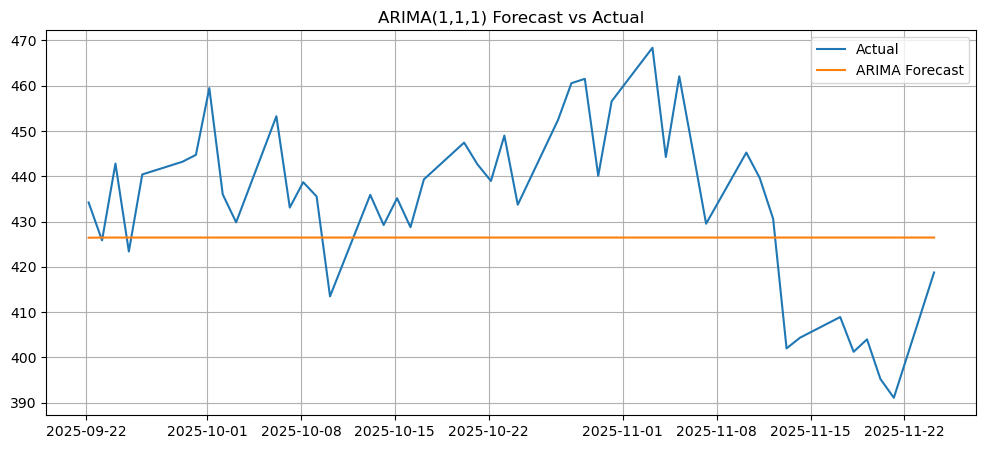

In [12]:
plt.figure(figsize=(12,5))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="ARIMA Forecast")
plt.grid(True)
plt.legend()
plt.title("ARIMA(1,1,1) Forecast vs Actual")
plt.show()
